# 以MNIST资料集训练VAE模型，并生成影像

In [1]:
# 载入相关套件
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from scipy.stats import norm

## 取得 MNIST 训练资料

In [2]:
# 取得 MNIST 训练资料
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr, x_te = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)

(60000, 784) (10000, 784)


## 定义编码器模型

In [3]:
# 超参数设定
batch_size, n_epoch = 100, 100  # 训练执行批量、周期
n_hidden, z_dim = 256, 2        # 编码器隐藏层神经元个数、输出层神经元个数

In [4]:
# encoder
x = Input(shape=(x_tr.shape[1:]))
x_encoded = Dense(n_hidden, activation='relu')(x)
x_encoded = Dense(n_hidden//2, activation='relu')(x_encoded)

# encoder 后接 Dense，估算平均数 mu
mu = Dense(z_dim)(x_encoded)

# encoder 后接 Dense，估算 log 变异数 log_var
log_var = Dense(z_dim)(x_encoded)

## 定义抽样函数

In [5]:
# 定义抽样函数
def sampling(args):
    # 根据 mu, log_var 取随机乱数
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

# 定义匿名函数，进行抽样
z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

## 定义解码器模型

In [6]:
# decoder
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr.shape[1], activation='sigmoid')

# 解码的输入为匿名函数
z_decoded = z_decoder1(z)
z_decoded = z_decoder2(z_decoded)
y = y_decoder(z_decoded)

## 定义特殊的损失函数(loss)

In [7]:
# 定义特殊的损失函数(loss)
reconstruction_loss = tf.keras.losses.binary_crossentropy(x, y) * x_tr.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
vae_loss = reconstruction_loss + kl_loss

vae = Model(x, y)   # x:MNIST图像， y:解码器的输出
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

# 显示模型汇总资讯
vae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          32896       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            258         dense_1[0][0]                    
______________________________________________________________________________________________

## 训练模型

In [8]:
# 训练模型
vae.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Epoch 1/100
600/600 [==============================] - 6s 8ms/step - loss: 232.5269 - val_loss: 165.5217
Epoch 2/100
600/600 [==============================] - 4s 7ms/step - loss: 162.8395 - val_loss: 157.3140
Epoch 3/100
600/600 [==============================] - 4s 7ms/step - loss: 156.4081 - val_loss: 153.3128
Epoch 4/100
600/600 [==============================] - 4s 7ms/step - loss: 153.2662 - val_loss: 151.3296
Epoch 5/100
600/600 [==============================] - 4s 7ms/step - loss: 151.0279 - val_loss: 149.8062
Epoch 6/100
600/600 [==============================] - 4s 7ms/step - loss: 149.2683 - val_loss: 148.9120
Epoch 7/100
600/600 [==============================] - 3s 6ms/step - loss: 147.5405 - val_loss: 147.2711
Epoch 8/100
600/600 [==============================] - 3s 6ms/step - loss: 146.5201 - val_loss: 145.5600
Epoch 9/100
600/600 [==============================] - 3s 6ms/step - loss: 145.2153 - val_loss: 144.5564
Epoch 10/100
600/600 [==============================] -

600/600 [==============================] - 3s 6ms/step - loss: 134.2453 - val_loss: 137.7324
Epoch 79/100
600/600 [==============================] - 3s 6ms/step - loss: 134.3424 - val_loss: 137.8496
Epoch 80/100
600/600 [==============================] - 3s 6ms/step - loss: 134.0985 - val_loss: 137.7865
Epoch 81/100
600/600 [==============================] - 3s 6ms/step - loss: 134.0359 - val_loss: 137.5385
Epoch 82/100
600/600 [==============================] - 3s 6ms/step - loss: 134.0945 - val_loss: 138.4910
Epoch 83/100
600/600 [==============================] - 3s 6ms/step - loss: 133.5870 - val_loss: 137.6712
Epoch 84/100
600/600 [==============================] - 3s 6ms/step - loss: 134.6031 - val_loss: 138.1873
Epoch 85/100
600/600 [==============================] - 3s 6ms/step - loss: 134.0664 - val_loss: 138.4747
Epoch 86/100
600/600 [==============================] - 3s 6ms/step - loss: 133.7581 - val_loss: 137.1729
Epoch 87/100
600/600 [==============================] - 3s 

## 取得编码器的输出，以测试资料预测，以编码器的输出绘图

In [9]:
# 取得编码器的输出 mu
encoder = Model(x, mu)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


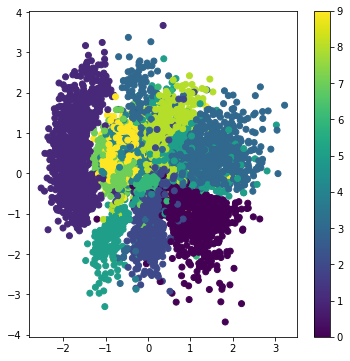

In [10]:
# 以测试资料预测，以编码器的输出绘图
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te)
plt.colorbar()
plt.show()

## 取得解码器的输出，以测试资料预测，以解码器的输出图像

In [11]:
# 取得解码器的输出
decoder_input = Input(shape=(z_dim,))
_z_decoded = z_decoder1(decoder_input)
_z_decoded = z_decoder2(_z_decoded)
_y = y_decoder(_z_decoded)
generator = Model(decoder_input, _y)
generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              multiple                  384       
_________________________________________________________________
dense_5 (Dense)              multiple                  33024     
_________________________________________________________________
dense_6 (Dense)              multiple                  201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


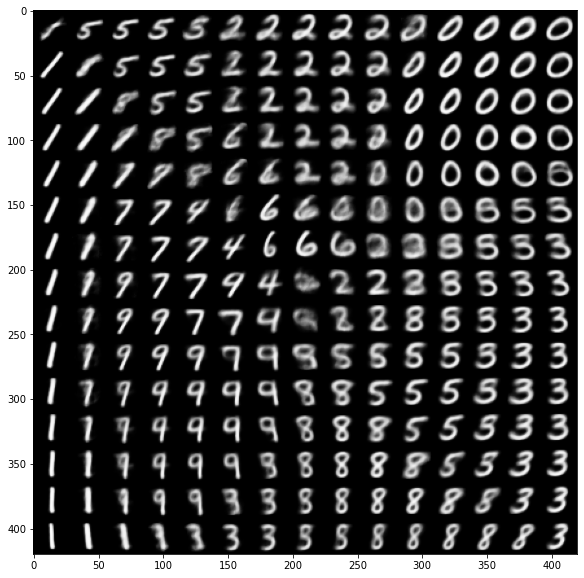

In [12]:
# 显示 2D manifold 
n = 15           # 显示 15x15 视窗
digit_size = 28  # 图像尺寸
figure = np.zeros((digit_size * n, digit_size * n))

# 
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# 取得各种机率下的生成的样本
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()